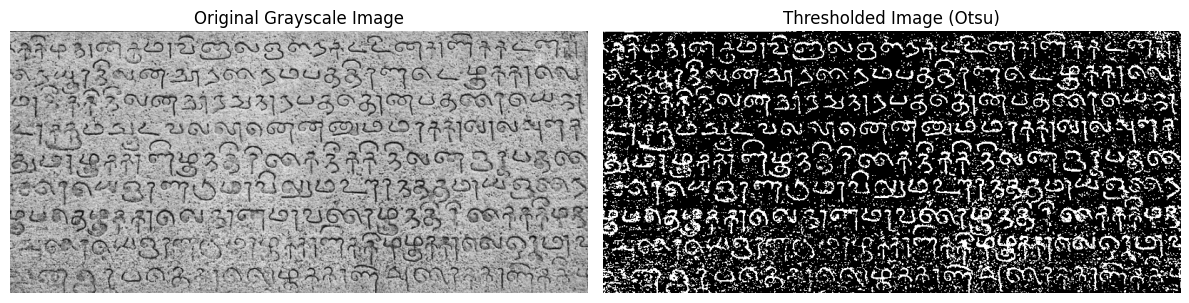

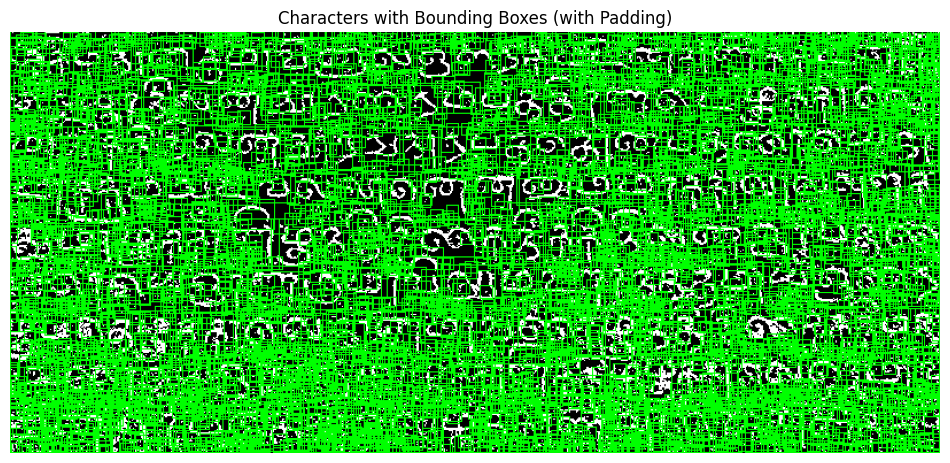

Total 5217 characters saved in 'segmented_characters' folder.


In [10]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread('./photo3.png', cv2.IMREAD_GRAYSCALE)
inverted_img = cv2.bitwise_not(img)  # Invert to get white text, black background

# Pre-processing: Apply Otsu's threshold
_, binary_img = cv2.threshold(inverted_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Create a folder to save characters
output_dir = 'segmented_characters'
os.makedirs(output_dir, exist_ok=True)

# Visualization of Preprocessing
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original Grayscale Image')
axs[1].imshow(binary_img, cmap='gray')
axs[1].set_title('Thresholded Image (Otsu)')
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

# Line Segmentation
def segment_lines(binary_img):
    horizontal_projection = np.sum(binary_img, axis=1)
    lines = []
    start = None
    for i, val in enumerate(horizontal_projection):
        if val > 0 and start is None:
            start = i
        elif val == 0 and start is not None:
            lines.append((start, i))
            start = None
    if start is not None:
        lines.append((start, len(horizontal_projection)))
    return lines

# Word Segmentation
def segment_words(line_img):
    vertical_projection = np.sum(line_img, axis=0)
    words = []
    start = None
    for i, val in enumerate(vertical_projection):
        if val > 0 and start is None:
            start = i
        elif val == 0 and start is not None:
            words.append((start, i))
            start = None
    if start is not None:
        words.append((start, len(vertical_projection)))
    return words

# Character Segmentation
def segment_characters(word_img):
    num_labels, labels_im = cv2.connectedComponents(word_img)
    chars = []
    boxes = []
    for label in range(1, num_labels):
        ys, xs = np.where(labels_im == label)
        if len(xs) == 0 or len(ys) == 0:
            continue
        x_min, x_max = xs.min(), xs.max()
        y_min, y_max = ys.min(), ys.max()
        boxes.append((x_min, y_min, x_max, y_max))
    boxes = sorted(boxes)  # Sort left to right
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        char_img = word_img[y_min:y_max+1, x_min:x_max+1]
        chars.append((char_img, box))
    return chars

# Main Process
boxed_image = cv2.cvtColor(binary_img.copy(), cv2.COLOR_GRAY2BGR)  # For drawing colored boxes

char_count = 0
padding = 5  # <-- Add padding here (in pixels)

for idx, (start_y, end_y) in enumerate(segment_lines(binary_img)):
    line_img = binary_img[start_y:end_y, :]
    words = segment_words(line_img)
    for w_idx, (start_x, end_x) in enumerate(words):
        word_img = line_img[:, start_x:end_x]
        chars = segment_characters(word_img)
        for c_idx, (char_img, (x_min, y_min, x_max, y_max)) in enumerate(chars):
            # Calculate full coordinates relative to original image
            full_x_min = max(start_x + x_min - padding, 0)
            full_x_max = min(start_x + x_max + padding, binary_img.shape[1]-1)
            full_y_min = max(start_y + y_min - padding, 0)
            full_y_max = min(start_y + y_max + padding, binary_img.shape[0]-1)

            # Draw rectangle with padding
            cv2.rectangle(boxed_image, (full_x_min, full_y_min), (full_x_max, full_y_max), (0, 255, 0), 1)

            # Crop the character from original binary image
            cropped_char = binary_img[full_y_min:full_y_max+1, full_x_min:full_x_max+1]

            # Optional: Center character on white canvas
            canvas_size = 64
            h, w = cropped_char.shape
            scale = min((canvas_size-10)/w, (canvas_size-10)/h)
            resized_char = cv2.resize(cropped_char, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)
            canvas = np.ones((canvas_size, canvas_size), dtype=np.uint8) * 255  # White canvas
            x_offset = (canvas_size - resized_char.shape[1]) // 2
            y_offset = (canvas_size - resized_char.shape[0]) // 2
            canvas[y_offset:y_offset+resized_char.shape[0], x_offset:x_offset+resized_char.shape[1]] = 255 - resized_char

            # Save the character
            filename = f'line_{idx+1}_word_{w_idx+1}_char_{c_idx+1}.png'
            save_path = os.path.join(output_dir, filename)
            cv2.imwrite(save_path, canvas)
            char_count += 1

# Display image with bounding boxes
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(boxed_image, cv2.COLOR_BGR2RGB))
plt.title('Characters with Bounding Boxes (with Padding)')
plt.axis('off')
plt.show()

print(f"Total {char_count} characters saved in '{output_dir}' folder.")

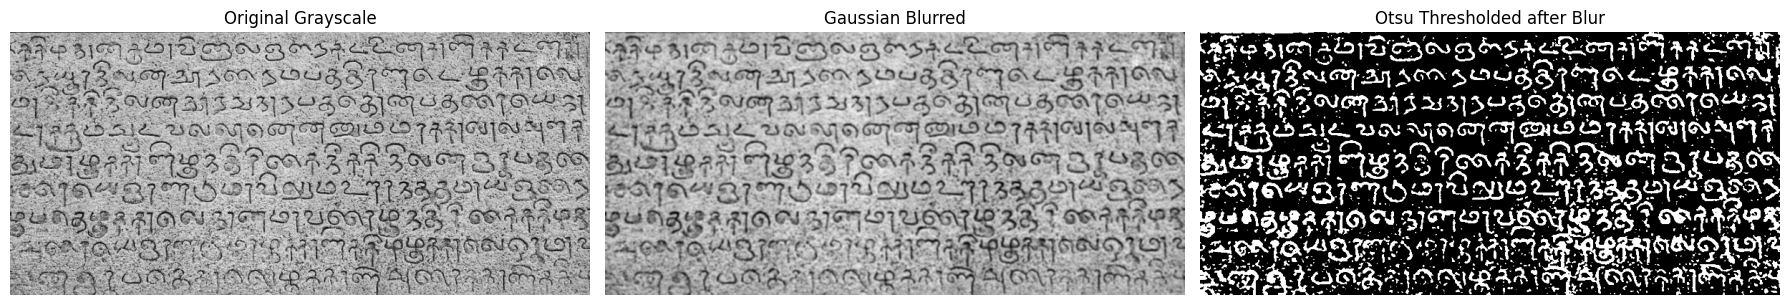

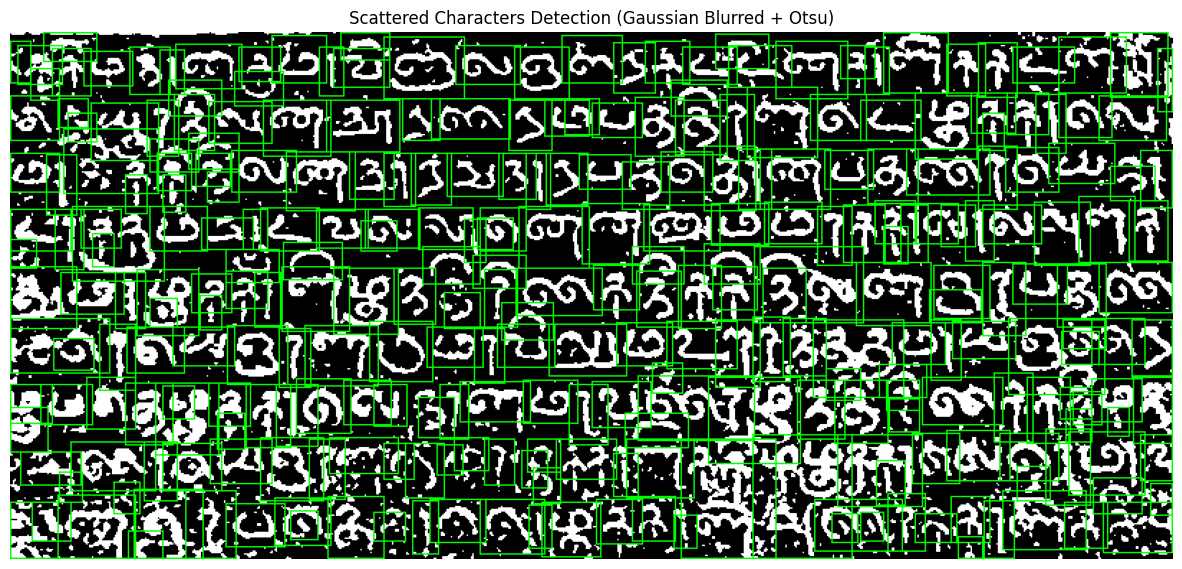

Total 296 characters saved in 'segmented_scattered_characters' folder.


In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread('./photo3.png', cv2.IMREAD_GRAYSCALE)

# Apply Gaussian blur
blurred_img = cv2.GaussianBlur(img, (5, 5), 0)

# Invert and apply Otsu's thresholding
inverted_img = cv2.bitwise_not(blurred_img)
_, binary_img = cv2.threshold(inverted_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Create output directory
output_dir = 'segmented_scattered_characters'
os.makedirs(output_dir, exist_ok=True)

# Visualize preprocessing
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original Grayscale')
axs[1].imshow(blurred_img, cmap='gray')
axs[1].set_title('Gaussian Blurred')
axs[2].imshow(binary_img, cmap='gray')
axs[2].set_title('Otsu Thresholded after Blur')
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

# Find contours (external characters)
contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# For visualization: copy image
boxed_image = cv2.cvtColor(binary_img.copy(), cv2.COLOR_GRAY2BGR)

# Character extraction parameters
padding = 5
canvas_size = 64
char_count = 0

# Sort contours top-to-bottom, then left-to-right
bounding_boxes = [cv2.boundingRect(c) for c in contours]
contours = [c for _, c in sorted(zip(bounding_boxes, contours), key=lambda b: (b[0][1], b[0][0]))]

for idx, cnt in enumerate(contours):
    x, y, w, h = cv2.boundingRect(cnt)

    # Filter out small noise components
    if w < 5 or h < 10:
        continue  # Ignore tiny blobs, not letters

    # Add padding
    full_x_min = max(x - padding, 0)
    full_y_min = max(y - padding, 0)
    full_x_max = min(x + w + padding, binary_img.shape[1]-1)
    full_y_max = min(y + h + padding, binary_img.shape[0]-1)

    # Draw rectangle for visualization
    cv2.rectangle(boxed_image, (full_x_min, full_y_min), (full_x_max, full_y_max), (0, 255, 0), 1)

    # Crop and prepare the character
    cropped_char = binary_img[full_y_min:full_y_max+1, full_x_min:full_x_max+1]

    # Resize and center on canvas
    h_crop, w_crop = cropped_char.shape
    scale = min((canvas_size-10)/w_crop, (canvas_size-10)/h_crop)
    resized_char = cv2.resize(cropped_char, (int(w_crop*scale), int(h_crop*scale)), interpolation=cv2.INTER_AREA)

    canvas = np.ones((canvas_size, canvas_size), dtype=np.uint8) * 255  # white canvas
    x_offset = (canvas_size - resized_char.shape[1]) // 2
    y_offset = (canvas_size - resized_char.shape[0]) // 2
    canvas[y_offset:y_offset+resized_char.shape[0], x_offset:x_offset+resized_char.shape[1]] = 255 - resized_char

    # Save
    filename = f'char_{idx+1}.png'
    save_path = os.path.join(output_dir, filename)
    cv2.imwrite(save_path, canvas)
    char_count += 1

# Show all bounding boxes
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(boxed_image, cv2.COLOR_BGR2RGB))
plt.title('Scattered Characters Detection (Gaussian Blurred + Otsu)')
plt.axis('off')
plt.show()

print(f"Total {char_count} characters saved in '{output_dir}' folder.")


In [ ]:
import cv2
import os

# Load the input image
image = cv2.imread('./photo3.png')  # Replace with your image filename
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Convert to binary image (thresholding)
_, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

# Find contours
contours, _ = cv2.findContours(
    binary,
    mode=cv2.RETR_EXTERNAL,  # Only outer contours
    method=cv2.CHAIN_APPROX_TC89_KCOS  # For curved shapes
)

# Create a directory to save the segmented characters
output_dir = 'segmented_characters'
os.makedirs(output_dir, exist_ok=True)

# Loop through contours and save each character
for i, contour in enumerate(contours):
    # Get bounding box
    x, y, w, h = cv2.boundingRect(contour)

    # Extract the character
    character = image[y:y+h, x:x+w]

    # Save the character image
    character_filename = os.path.join(output_dir, f'char_{i}.png')
    cv2.imwrite(character_filename, character)

    # Optionally, draw rectangles for visualization
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Show the result
cv2.imshow('Segmented Characters', image)
cv2.waitKey(0)
cv2.destroyAllWindows()